# 03. rajpurohitpooja/Salary_Prediction_Portfolio

## Prediction & XAI with XGBoost (T1) - train_features.csv & test_features.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import lime, shap
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression, Lasso, Ridge, QuantileRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, get_scorer_names
df = pd.read_csv('03_train_features.csv')
df_salary = pd.read_csv('03_train_salaries.csv')

C:\Users\Doğan Yiğit Yenigün\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Merge these two datasets with 'jobId' column; then show all the columns, counts and their data types
df = df.merge(df_salary, on='jobId')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [3]:
# First 5 rows of the dataset
df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


## Prepare Train and Test Sets

In [4]:
# Create dummy variables from these columns: jobType, degree, major, industry
dummy_jobtype = pd.get_dummies(df['jobType'], prefix='job')
dummy_degree = pd.get_dummies(df['degree'], prefix='deg')
dummy_major = pd.get_dummies(df['major'], prefix='maj')
dummy_industry = pd.get_dummies(df['industry'], prefix='ind')
df_concat = pd.concat([dummy_jobtype, dummy_degree, dummy_major, dummy_industry,
                       df['yearsExperience'], df['milesFromMetropolis'], df['salary']], axis=1)
df_concat.head(10)

,job_CEO,job_CFO,job_CTO,job_JANITOR,job_JUNIOR,job_MANAGER,job_SENIOR,job_VICE_PRESIDENT,deg_BACHELORS,deg_DOCTORAL,...,ind_AUTO,ind_EDUCATION,ind_FINANCE,ind_HEALTH,ind_OIL,ind_SERVICE,ind_WEB,yearsExperience,milesFromMetropolis,salary
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,10,83,130
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,3,73,101
2,0,0,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,10,38,137
3,0,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,8,17,142
4,0,0,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,8,16,163
5,0,0,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,2,31,113
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,23,24,178
7,0,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,9,70,73
8,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,54,31
9,0,0,0,0,0,0,0,1,1,0,...,1,0,0,0,0,0,0,17,68,104


### Type 1: Use All Columns

In [5]:
# Use 80% of the dataset as train set, and 20% as test set
X = df_concat.drop(columns='salary', axis=1)
Y = df_concat.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=21)
print("TRAIN SIZE:", x_train.shape, y_train.shape, "  TEST SIZE:", x_test.shape, y_test.shape)

TRAIN SIZE: (800000, 31) (800000,)   TEST SIZE: (200000, 31) (200000,)


## Predict with XGBoost

In [6]:
xgb = xgboost.XGBRegressor()
xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [7]:
# Fit the training data into the extreme gradient boosting regression model, then make predictions on the test data
s_time = time.time()
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 5.685 seconds.


In [8]:
# Compare the predicted values against the actual ones for the top 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

   94.25157928466797 |       73
  125.50593566894531 |      100
  126.61891174316406 |      101
  127.32078552246094 |      112
   118.7073974609375 |      130
  108.66679382324219 |      108
  116.02254486083984 |      130
   53.67390060424805 |       43
   189.6204071044922 |      174
    92.7608642578125 |       88
  105.73955535888672 |      103
   172.6977081298828 |      162
   82.91378784179688 |       73
  108.14832305908203 |       96
   131.7954864501953 |      121
   156.1629638671875 |      187
  139.32913208007812 |      173
   92.02782440185547 |       89
  104.64934539794922 |      106
  121.75745391845703 |      160


In [9]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print("MSE:", mse)        
print("RMSE:", rmse)      
print("MAE:", mae)        
print("R2 SCORE:", r2)  
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(xgb, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())

MSE: 358.53993012002655
RMSE: 18.935150649520235
MAE: 15.378409626455307
R2 SCORE: 0.7618266706470885

# CROSS VALIDATION #
FITTING TIME: [5.59650183 5.74455333 5.8862741  5.14920616 5.84785008] -> 5.644877099990845
SCORING TIME: [0.12857938 0.1492579  0.16193438 0.14078832 0.14068842] -> 0.14424967765808105
TRAIN SCORE: [0.76511612 0.76463375 0.76527849 0.76481091 0.7646614 ] -> 0.7649001347028642
TEST SCORE: [0.76044439 0.76061531 0.76088225 0.76101554 0.76102936] -> 0.7607973686139663


## Explain the Model with SHAP

In [10]:
shap.initjs()
shap_explainer = shap.Explainer(xgb, x_train)
shap_values = shap_explainer(x_test)
print(shap_values.shape)
print(shap_values)
print("\n EXPECTED VALUE:", shap_explainer.expected_value)

100%|===================| 199698/200000 [11:01<00:00]        

(200000, 31)
.values =
array([[ -3.0567357 ,  -1.21682637,  -1.53242598, ...,  -0.87159446,
          0.43672046,   6.75760878],
       [ -2.15104142,  -0.64748146,   9.55661842, ...,  -0.9139905 ,
          3.32472587,  -1.61670672],
       [ -3.29879507,  -1.12718228,  -1.51508873, ...,  -0.46454196,
          3.36146665,  -2.19386845],
       ...,
       [ -3.19460639,  -1.1428649 ,  -1.3068695 , ...,  -0.46816811,
        -18.46715043,   4.9788166 ],
       [ -2.67254527,  -0.88381289,  -1.05768109, ...,   3.06101021,
        -17.03558935, -12.52956156],
       [ -2.62207213,  -0.76343697,  -1.02579562, ...,  -0.76816632,
        -20.72820228,  -9.55513328]])

.base_values =
array([122.54176357, 122.54176357, 122.54176357, ..., 122.54176357,
       122.54176357, 122.54176357])

.data =
array([[ 0,  0,  0, ...,  0, 13, 33],
       [ 0,  0,  1, ...,  0, 14, 54],
       [ 0,  0,  0, ...,  0, 15, 53],
       ...,
       [ 0,  0,  0, ...,  0,  4, 34],
       [ 0,  0,  0, ...,  1,  2, 90

### SUMMARY OF EXPLAINABILITY WITH SHAP ###


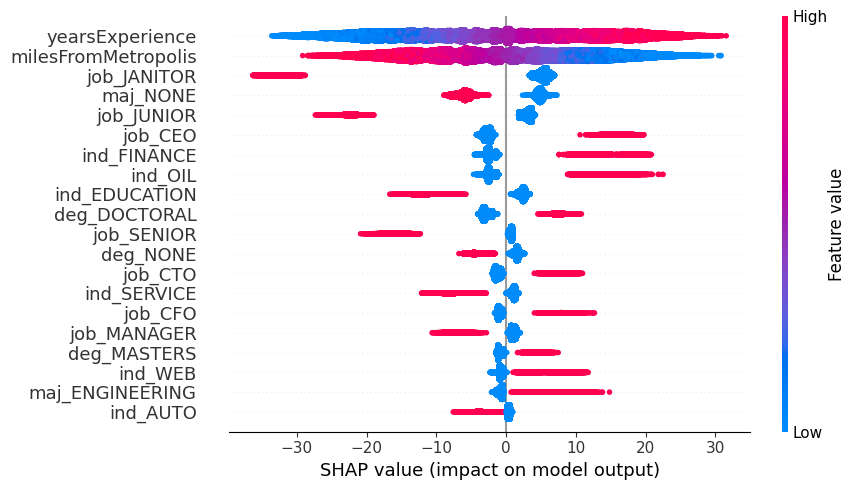

In [11]:
print("### SUMMARY OF EXPLAINABILITY WITH SHAP ###")
# shap.plots.beeswarm(shap_values)
shap.summary_plot(shap_values, x_test, plot_type='dot', plot_size=[9,5])

In [12]:
print("### VISUALIZATION OF FIRST 500 PREDICTIONS ###")
shap.plots.force(shap_values[:500])

### VISUALIZATION OF FIRST 500 PREDICTIONS ###


### MEAN ABSOLUTE VALUES OF SHAP VALUES ###


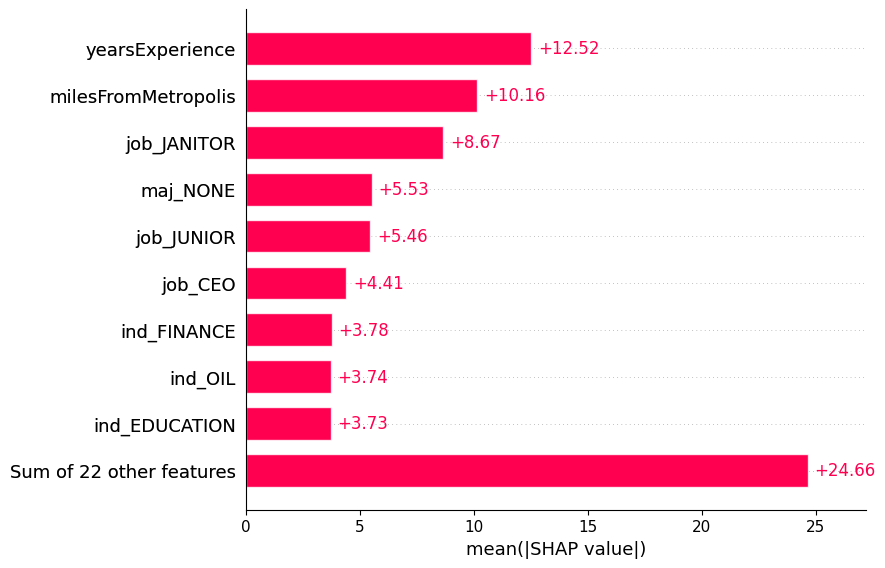

In [13]:
print("### MEAN ABSOLUTE VALUES OF SHAP VALUES ###")
shap.plots.bar(shap_values)

### DEPENDENCY BETWEEN THE FIRST COLUMN & THE BEST INTERACTION ###


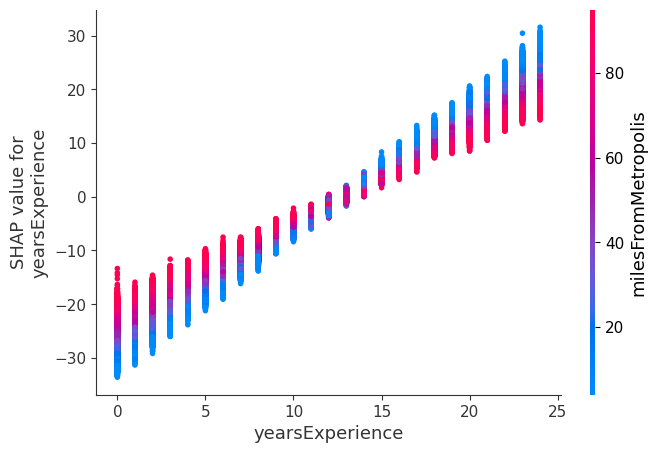

In [14]:
print("### DEPENDENCY BETWEEN THE FIRST COLUMN & THE BEST INTERACTION ###")
shap.dependence_plot("yearsExperience", shap_values.values, x_test)

### EXPLAINING TEST ROW 192439 WITH SHAP ###


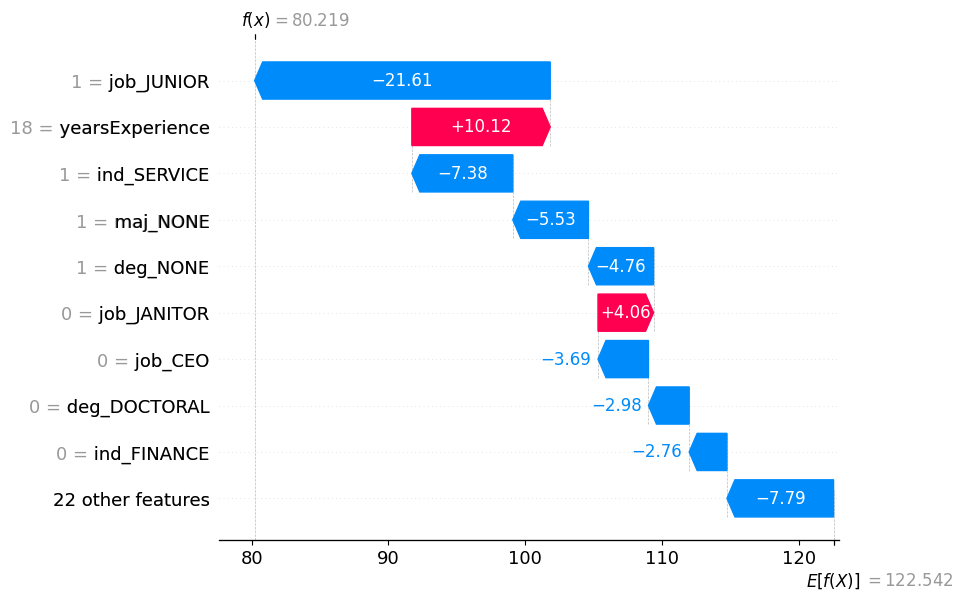

In [19]:
# i = 0
import random
i = random.randint(0, x_test.shape[0]-1)
print("### EXPLAINING TEST ROW {} WITH SHAP ###".format(i))
shap.plots.waterfall(shap_values[i])

In [20]:
print("### EXPLAINING TEST ROW {} WITH SHAP ###".format(i))
shap.plots.force(shap_values[i])

### EXPLAINING TEST ROW 192439 WITH SHAP ###


## Explain the Model with LIME

In [21]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values, feature_names=df_concat.columns, 
                                                        class_names=['salary'], verbose=True, mode='regression')

In [22]:
i = random.randint(0, x_test.shape[0]-1)
print("### EXPLAINING TEST ROW {} WITH LIME ###".format(i))
exp = lime_explainer.explain_instance(x_test.iloc[i], xgb.predict, num_features=10)
exp.show_in_notebook(show_table=True)
exp.as_list()

### EXPLAINING TEST ROW 60560 WITH LIME ###
Intercept 111.32132151283582
Prediction_local [107.0772663]
Right: 84.471756


[('job_JANITOR <= 0.00', 35.57970377552493),
 ('job_JUNIOR > 0.00', -22.71321389563442),
 ('milesFromMetropolis <= 25.00', 20.155451502229887),
 ('job_CEO <= 0.00', -16.78842547527706),
 ('ind_EDUCATION <= 0.00', 14.68623107640533),
 ('ind_FINANCE <= 0.00', -14.390045771865458),
 ('job_SENIOR <= 0.00', 13.6082758729272),
 ('ind_OIL <= 0.00', -13.111104461863091),
 ('0.00 < maj_NONE <= 1.00', -10.825950612911907),
 ('deg_DOCTORAL <= 0.00', -10.444977226257766)]